# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from scipy.stats import beta
import math
import seaborn as sns
import plotly.express as px
#from adjustText import adjust_text
#import gseapy as gp

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

In [2]:
def production_decay_ode(y, time, rho, s0, es, k0, ek, tk ):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    rho: splicing rate
    s0: transcription constant
    es: relative amplitude of the transcription rate oscillation
    ek: relative amplitude of the mRNA degradation rate oscillation
    k0: degradation constant
    time: time point (in minutes)
    tk: time for maximum degradation rate
    
    st: transcription rate (time dependent)
    
    """
    omega = 2*np.pi/(24*60)
    P, M = y
    st = s0*(1+es*np.cos(omega*time))
    kt = k0*(1+ek*np.cos(omega*(time-tk)))
    dPdt = st - rho*P
    dMdt = rho*P - kt*M
    return [dPdt, dMdt] 

def simulation(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
   
    s = parameters['s']
    kp = parameters['kp']
    km = parameters['km']
    rho = parameters['rho']
    tau = parameters['tau']
    kg = parameters['kg']
    """
    
    rho= parameters['rho']
    s0= parameters['s0']
    es= parameters['es']
    k0= parameters['k0']
    ek= parameters['ek']
    tk= parameters['tk']
    
    #results = odeint(ode_function, initial_conditions, time, args=(rho, s0, es, k0, ek, tk))
    results = odeint(ode_function, initial_conditions, time, args=(rho, s0, es, k0, ek, tk))

    plt.figure(figsize=(7, 4))

    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    plt.plot(time, results[:, 0], label = 'P(t)', linewidth=2, color='blue')
    plt.legend(loc='lower left')
    plt.xlabel("Time [min]")
    plt.ylabel("Pre-mRNA concentration P(t)")
    plt.twinx()
    plt.plot(time, results[:, 1], label = 'M(t)', linewidth=2, color='orange')
    plt.legend(loc='lower right')
    plt.ylabel("mRNA Concentration M(t)")
    
    # Uncomment the lines below after adding your steady-state solutions
    #omega = 2*np.pi/(24*60)
    #st = s0*(1+es*math.cos(omega*time))
    #kt = k0*(1+ek*math.cos(omega*(time-tk)))
    #P_ss = s0 / rho #Add your steady-state solution for P here 
    #M_ss = s0 / k0 #Add you steady-state solution for M here
    #plt.axhline(y=P_ss, color='blue', linestyle='--', label='P_ss')  
    #plt.axhline(y=M_ss, color='orange', linestyle='--', label='M_ss')
    
    plt.show()
    
def animate(initial_conditions, time, rho=0.2, s0=10, es=1, k0=0.05, ek=1, tk=0.5):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
    parameters = {'rho':rho, 's0':s0, 'es':es, 'k0':k0, 'ek':ek, 'tk':tk}
    simulation(production_decay_ode, parameters, initial_conditions, time)


In [3]:
# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 10000, 10001)

interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
        rho=(1/30, 1, 0.05), #splicing rate 1/rho = 1 to 30 min
        s0=(0, 10, 0.1),
        es=(0, 1, 0.1),
        k0=(0.0001,0.1,0.0001), #degradation rate 1/k0 = 10 min to a few hours (1000 min)
        ek=(0, 1, 0.1),
        tk=(0, 24*60, 1)); #shift from 0 to 24h

interactive(children=(FloatSlider(value=0.2, description='rho', max=1.0, min=0.03333333333333333, step=0.05), …

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

**Answer 2.** The 3 plots below show 3 simulations with increasing value of $k_{0}$. When $k_{0}$ approches 0 the the half-life of mRNA tends to infinity (it never degrades). Oscillations are less and less perceptible and the phase delay tends to $\frac{\pi}{2}$. When $k_{0}$ increases the phase delay tends to zero. Both concentration signals are in phase.

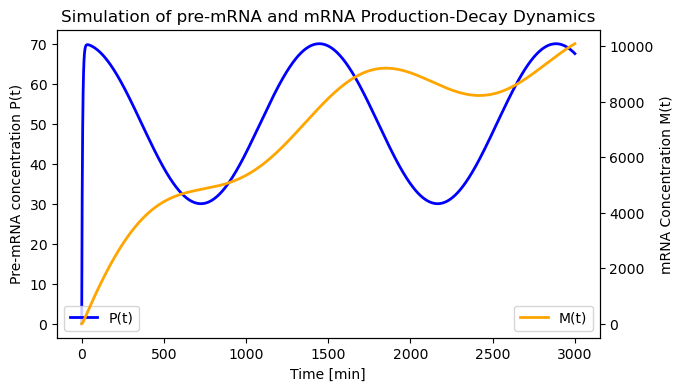

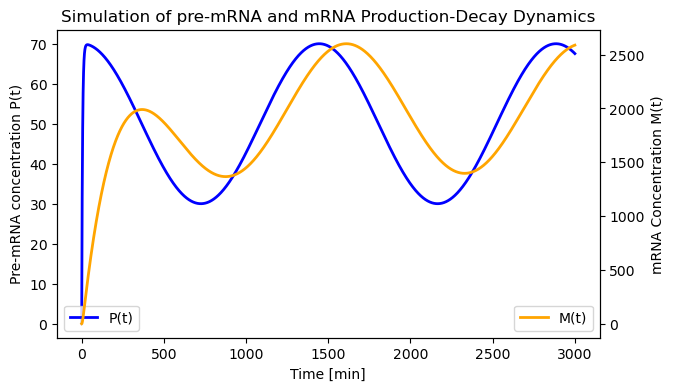

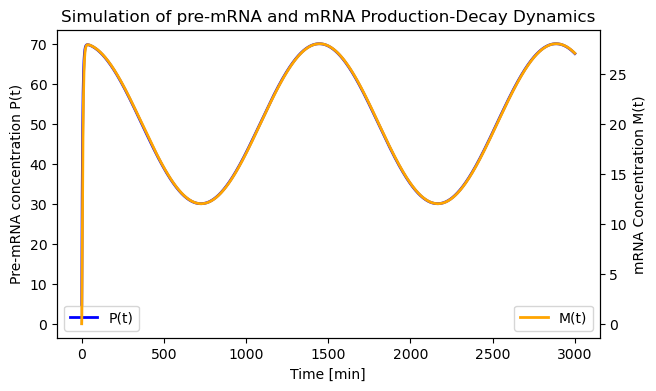

In [4]:
# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 3000, 10001)

parameters_bigdelay = {'rho':0.2, 's0':10, 'es':0.4, 'k0':0.001, 'ek':0, 'tk':0}
simulation(production_decay_ode, parameters_bigdelay, initial_conditions, time)

parameters_bigdelay = {'rho':0.2, 's0':10, 'es':0.4, 'k0':0.005, 'ek':0, 'tk':0}
simulation(production_decay_ode, parameters_bigdelay, initial_conditions, time)

parameters_smalldelay = {'rho':0.2, 's0':10, 'es':0.4, 'k0':0.5, 'ek':0, 'tk':0}
simulation(production_decay_ode, parameters_smalldelay, initial_conditions, time)


3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulatiokn when the synthesis is constant ($\epsilon_s=0$). 
    * Explore and discuss scenarios where the introduction of rhythmic degradation leads to dynamics that cannot be achieved with a constant half-life.  
    
    See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

**Answer 3.** For a constant pre-mRNA expression ($\epsilon_s = 0$) and a rythmic degradation ($\epsilon_k ≠ 0$) one can reach a periodic system where mRNA are always present and accumulate rythmicly. Indeed, on the first plot below we see a basal level or mRNA (orange curve) (of approx. 130). When mRNA is not degraded anymore, it accumulates until 400 before degradation re-switches on.
If the half-life of the mRNA was constant, using the same other parameters one could not obtained a sinusoidal expression/accumulation of mRNA. The final concentration of mRNA would simply be constant and the profile of expression would look like a typical birth-death process. (see second plot, where ($\epsilon_k = 0$))


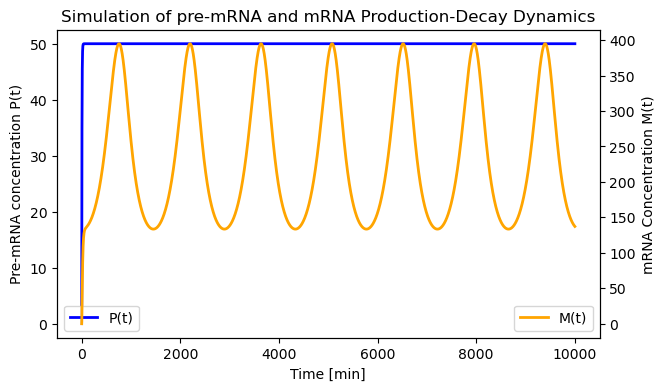

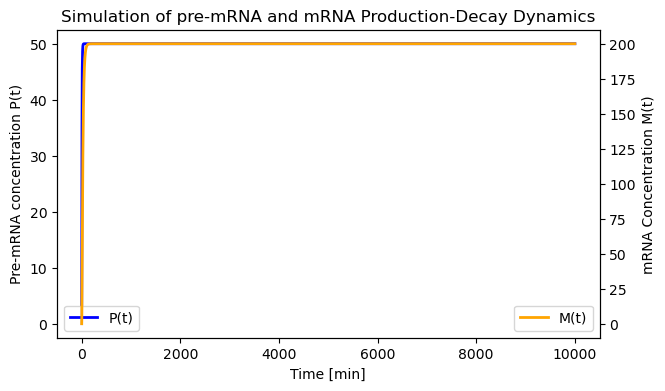

In [5]:
# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 10000, 10001)

parameters_bigdelay = {'rho':0.2, 's0':10, 'es':0, 'k0':0.05, 'ek':0.5, 'tk':0}
simulation(production_decay_ode, parameters_bigdelay, initial_conditions, time)

parameters_bigdelay = {'rho':0.2, 's0':10, 'es':0, 'k0':0.05, 'ek':0, 'tk':0}
simulation(production_decay_ode, parameters_bigdelay, initial_conditions, time)

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

In this exercise, we will analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12-hour light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to Week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Modify the code from Week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``.  
 First start with only the exons, then only the introns, and eventually both. Describe your observations.  

In [6]:
def subselect(data, feature, replicate, time, condition, feeding):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The temperature shift conditions to include (e.g, ['33to38', '38to33']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)
    feeding_mask = data.columns.get_level_values('feeding').isin(feeding)
    # Use the masks to filter the data

    #filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask & feeding_mask]
    return filtered_data

def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, log_transform=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.
    log_transform: Whether to apply log transformation to the data.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data
        
    if log_transform:
        data = np.log2(data + 1)
        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette='Set1')

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        # remove legend if it's not the first plot
        if i != 0:
            axes[i].get_legend().remove()
    
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)

    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca


## Plot Gene profile across all conditions
def plot_gene(data, gene , xx_33_38=None, xx_38_33=None, t_2=None):

    """
    Plots the gene expression profile across different conditions and time points.
    
    Parameters:
    data: The gene expression data.
    gene: The gene to plot.
    xx_33_38: The simulated solution for the 33to38 condition.
    xx_38_33: The simulated solution for the 38to33 condition.

    Returns:
    None
    """

    #subselect
    time= ['0', '1' ,'3' ,'6', '9']
    replicate = ['2', '13', '11', '5']
    dat_1= subselect(data, ['intron'], replicate, time, ['33to38'])
    dat_2= subselect(data, ['exon'], replicate, time, ['33to38'])
    dat_3= subselect(data, ['intron'], replicate, time, ['38to33'])
    dat_4= subselect(data, ['exon'], replicate, time, ['38to33'])

    #plot
    t=np.array([0, 0, 1, 1, 3, 3, 6, 6, 9 , 9])
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex=True)
    
    axs[0, 0].plot(t, dat_1[dat_1.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='intron 33to38')
    axs[0, 0].set_title("intron 33to38")
    
    axs[1, 0].plot(t, dat_2[dat_2.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='exon 33to38')
    axs[1, 0].set_title("exons 33to38")
    
    axs[0, 1].plot(t, dat_3[dat_3.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='intron 38to33')
    axs[0, 1].set_title("intron 38to33")

    axs[1, 1].plot(t, dat_4[dat_4.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='exon 38to33')
    axs[1, 1].set_title("exon 38to33")

    if xx_33_38 is not None:
        axs[0,0].plot(t_2, xx_33_38[:,0],label = 'P(t)')
        axs[1,0].plot(t_2, xx_33_38[:,1])
        axs[0,1].plot(t_2, xx_38_33[:,0])
        axs[1,1].plot(t_2, xx_38_33[:,1])
    
        
    for ax in axs.flat:
        ax.set(xlabel='Time [h]', ylabel='RPKM')

    fig.suptitle(f'Gene Expression Profile for {gene}', fontsize=16)
    plt.show()

def plot_DE(dat_all, condition_x1, condition_x2, condition_y1, condition_y2, time_x1, time_x2, time_y1, time_y2, feature_x1, feature_x2, feature_y1, feature_y2, FC=2, xlab="", ylab="", FC_type="delta"):
    
    """
    Plots differentially expressed genes based on log fold changes between specified conditions, times, and features.

    Parameters:
    dat_all: The complete dataset with gene expression values.
    condition_x1, condition_x2, condition_y1, condition_y2: Lists of conditions to compare.
    time_x1, time_x2, time_y1, time_y2: Lists of time points to compare.
    feature_x1, feature_x2, feature_y1, feature_y2: Lists of features to compare.
    FC: Absolute fold change threshold for considering a gene differentially expressed in at least one of the two axes.
    xlab: Label for the x-axis representing the log fold change between condition_x2 and condition_x1.
    ylab: Label for the y-axis representing the log fold change between condition_y2 and condition_y1.

    Returns:
    Array: Boolean array indicating differentially expressed genes that meet the fold change threshold.
    """
     
    replicate = ['2', '13', '11', '5']

    dat_x1=subselect(dat_all, feature_x1, replicate, time_x1, condition_x1).mean(axis=1)
    dat_x2=subselect(dat_all, feature_x2, replicate, time_x2, condition_x2).mean(axis=1)

    dat_y1=subselect(dat_all, feature_y1, replicate, time_y1, condition_y1).mean(axis=1)
    dat_y2=subselect(dat_all, feature_y2, replicate, time_y2, condition_y2).mean(axis=1)

    x=np.log2(1 + dat_x2)- np.log2(1 + dat_x1)
    y=np.log2(1 + dat_y2) - np.log2(1 + dat_y1)

    if FC_type == "delta":
        pos =((x > FC) & (y > FC)) | ((x < -FC) & (y < -FC))

    if FC_type == "delta_delta":
        pos = abs(x-y) > FC

    x_2 = x[pos]
    y_2 = y[pos]
    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(x,y, 'o', color = 'lightblue', markersize=2)
    ax.axhline(y=0, color='b')
    ax.axvline(x=0, color='b')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    texts = [ax.text(x_2[k], y_2[k], v.split("|")[1]) for k, v in enumerate(dat_all.index[pos])]
    adjust_text(texts)
    
    return(pos)    


In [7]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 

def return_amp_phase_pv(y, Ts, T, N):
    
    """
    Perform harmonic regression using a Fourier series to infer the amplitude, phase, p-value, and mean from a time series.

    Parameters:
    y: Time series data.
    Ts: Sampling interval.
    T: Period of the time series.
    N: Number of data points in the time series.

    Returns:
    tuple: A tuple containing amplitude, phase, p-value, and mean of the time series.

    Notes:
    - The function uses Fast Fourier Transform (FFT) to decompose the time series.
    - Harmonic regression is performed to fit a cosine wave to the data.
    - The p-value is calculated based on the fit statistics, providing an estimate of the fit quality.
    """
      
    # Time vector for the series
    t = np.linspace(0.0, N * Ts, N)

    # Fourier Transform
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)

    # Identify the frequency closest to 1/T
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))

    # Calculate amplitude and phase
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)

    # Mean of the time series
    mu = 1 / N * x_fft[0].real
    
    # Harmonic regression to compute residuals and statistics
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2

    # Compute p-value
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)

    # Adjust phase to be within [0, T]
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu


#### Load the RNA-seq data

In [8]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']
list_of_genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
# show the different variables in condition of dat_genes
#dat_genes.columns.get_level_values('time').unique()

#extract from dat the genes in list_of_genes  
dat_genes = dat.loc[list_of_genes]
dat_genes.head()


condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Arntl       -1.669041 -1.694083 -2.706959 -3.508204 -3.848818 -4.003520   
Npas2       -1.962732 -2.192843 -3.944118 -4.209720 -4.256702 -4.273067   
Clock       -1.597633 -1.549136 -1.794397 -1.740208 -2.561197 -2.653104   
Cry1        -3.015745 -2.888921 -3.226192 -3.355850 -3.444067 -2.907677   
Cry2        -2.125658 -1.418011 -1.267150 -0.570111 -0.933872 -0.568488   

condition                                            ...                      \
feeding                                              ...                       
feature                                              ...       RFP             
time               12        14        16        18  ...        04        06   
replicate           A         A         A         A  ...         D         D   
Gene_Symbol                                          ...                       
Arntl       -3.509194 -2.494314 -2.238684 -2.282043  ...  3.022983  1.673178   
Npas2       -4.269427 -4.246326 -4.237317 -4.149953  ... -0.111984 -3.286106   
Clock       -2.276997 -2.292100 -1.115022 -1.490327  ...  1.518437  1.848053   
Cry1        -2.312536 -1.554579 -1.367280 -1.529984  ...  1.572807  1.120746   
Cry2        -0.830493 -0.808692 -0.764942 -0.753802  ...  2.403922  3.050125   

condition                                                                \
feeding                                                                   
feature                                                                   
time               08        10        12        14        16        18   
replicate           D         D         D         D         D         D   
Gene_Symbol                                                               
Arntl       -0.323042 -1.531355  0.016196  1.502431  0.612706  3.621233   
Npas2       -3.129760 -3.995698 -4.009316 -4.020822 -3.073643 -0.001143   
Clock        1.144557  0.770371  1.090088  1.398042  1.619607  2.039359   
Cry1         0.413170  1.039117  1.978841  2.477187  0.829508  2.543046   
Cry2         3.369495  3.397454  3.530218  3.475627  3.426552  2.585690   

condition                        
feeding                          
feature                          
time               20        22  
replicate           D         D  
Gene_Symbol                      
Arntl        2.906462  3.175841  
Npas2       -2.603965 -0.873309  
Clock        1.611866  1.753404  
Cry1         3.048787  3.098065  
Cry2         3.121378  3.092411  

[5 rows x 144 columns]

In [9]:
time= ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']
replicate = ['A', 'B', 'C', 'D']
feeding = ['AL']
conditions = ['WT']
feature = ['Intron', 'Exon']

dat_intron = subselect(dat_genes, ['Intron'], replicate, time, conditions, feeding)
dat_exon = subselect(dat_genes, ['Exon'], replicate, time, conditions, feeding)
dat_both = subselect(dat_genes, feature, replicate, time, conditions, feeding)

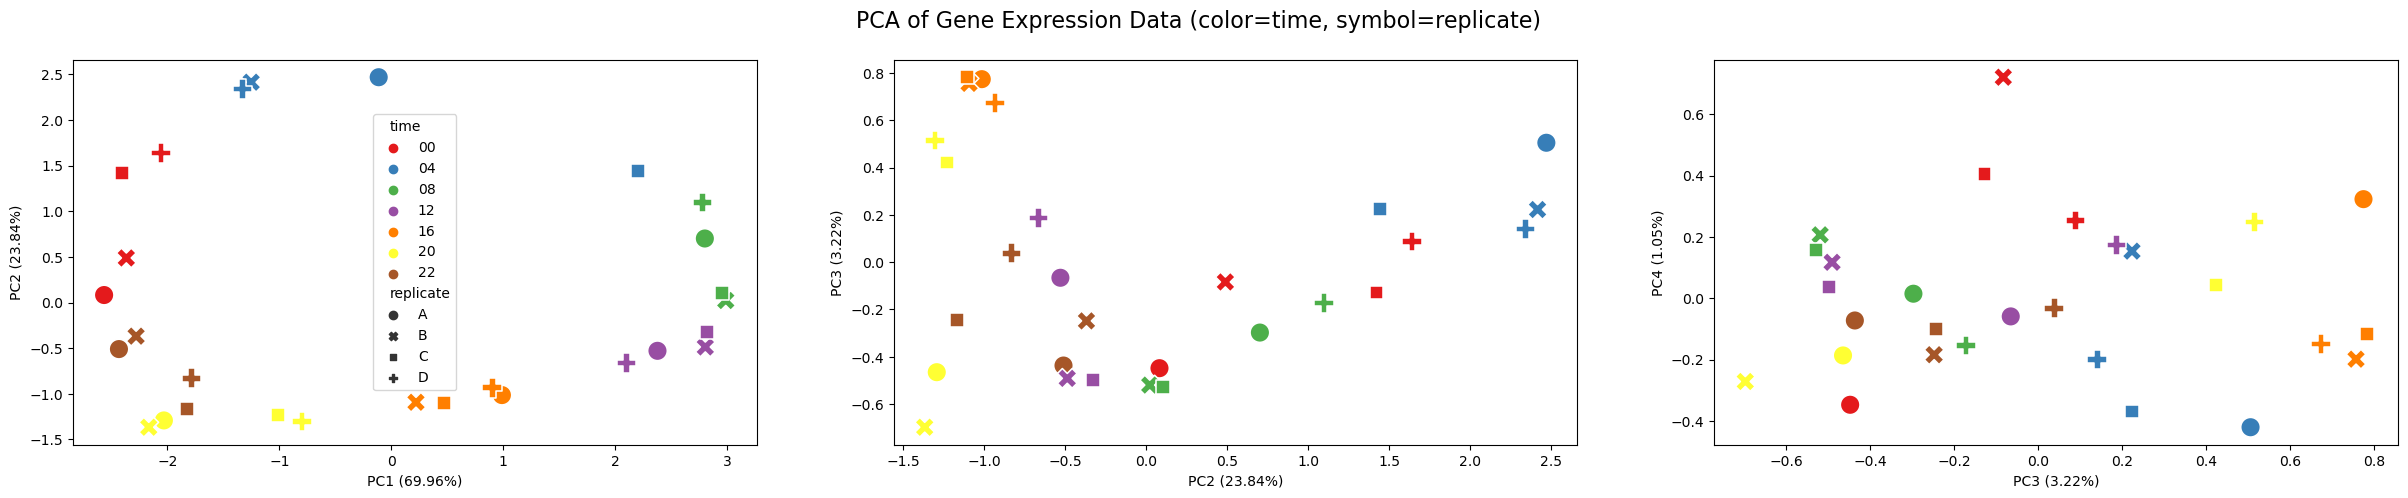

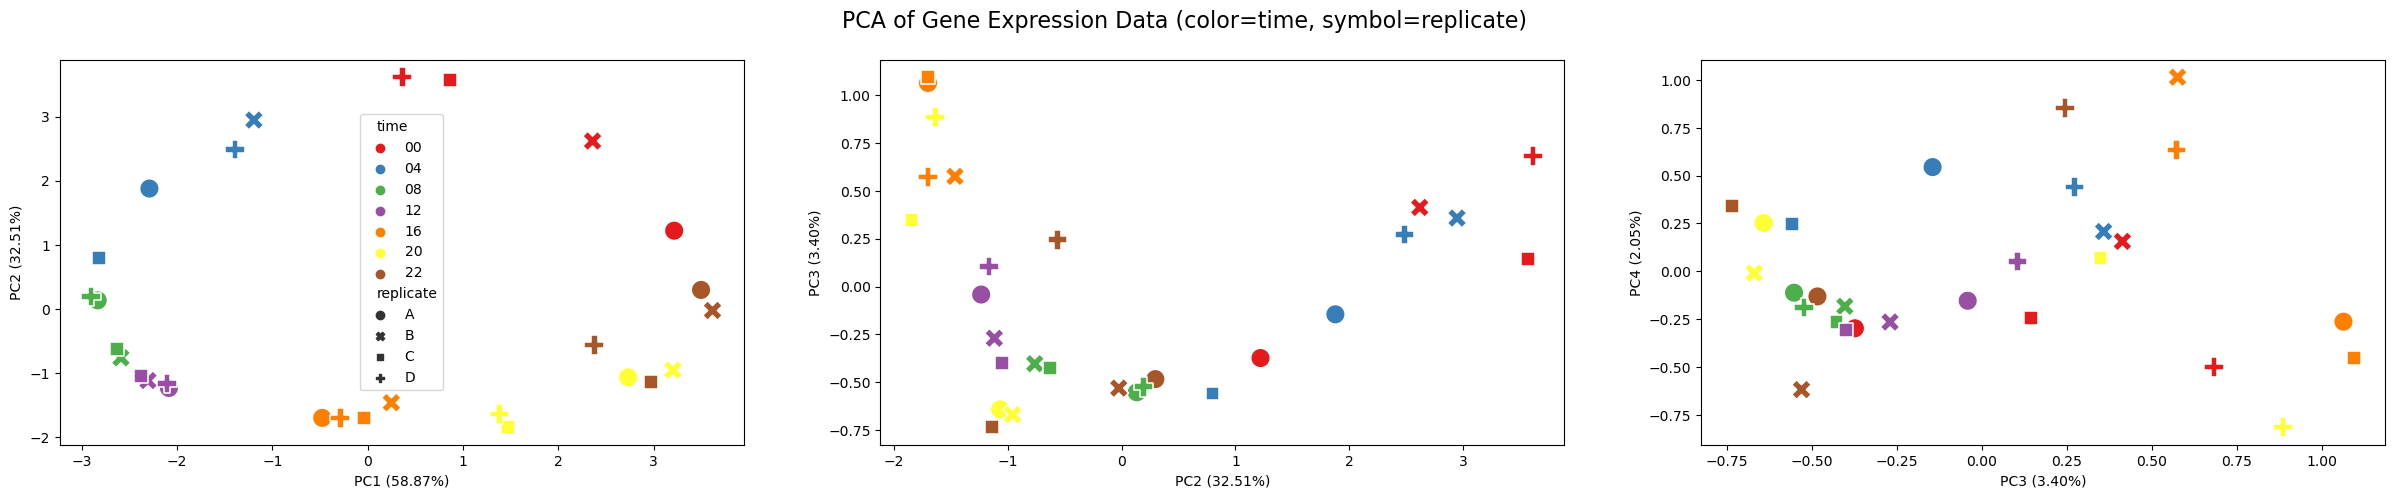

In [10]:
# Run PCA on the gene expression data
#time= ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']
time= ['00', '04', '08', '12', '16', '20','22']
replicate = ['A', 'B', 'C', 'D']
feeding = ['AL']
conditions = ['WT']
feature_exon = [ 'Exon']
feature_intron = ['Intron']
#Subselect the samples 
dat_exon_sub = subselect(dat_both, feature_exon, replicate, time, conditions, feeding)
dat_intron_sub = subselect(dat_both, feature_intron, replicate, time, conditions, feeding)

df_pca = run_PCA(dat_exon_sub, n_components=4, color_by='time', symbol_by='replicate', scale_data=True, log_transform=False)
df_pca = run_PCA(dat_intron_sub, n_components=4, color_by='time', symbol_by='replicate', scale_data=True, log_transform=False)

2. Use the *return_amp_phase_pv* function on the $log_2$ data to assess and characterize rhythmicity genome-wide.
    * Select genes based on p-value ($p<0.01) and amplitude (log2 fold-change>0.5) thresholds for further analysis.
    * Provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough) for the selected genes.
    * Perform this analysis separately for the exons and introns.
    * Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
    
3. Determine which genes show the highest amplitude rhythmic patterns. Are there any common themes or characteristics among these genes?

#### Assess rhythmicity

In [11]:
def process_data(data, feature_type, Ts, T, N):
    """
    Applies the return_amp_phase_pv function to all genes for a given feature type (intron or exon).

    Parameters:
    data: The dataset containing gene expression data.
    feature_type: Type of feature to process ('Intron' or 'Exon').
    Ts: Sampling time.
    T: Period.
    N: Number of samples.

    Returns:
    dict: A dictionary containing arrays for amplitude, phase, p-value, and mean for the specified feature type.
    """

    feature_pos = data.columns.get_level_values('feature').isin([feature_type])
    results = {'amp': [], 'phase': [], 'pv': [], 'mu': [], 'gene': []}

    for _, row in data.iterrows():
        a, p, pv, mu = return_amp_phase_pv(np.array(row)[feature_pos], Ts, T, N)
        results['amp'].append(a)
        results['phase'].append(p)
        results['pv'].append(pv)
        results['mu'].append(mu)
        results['gene'].append(row.name)

    # Convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])

    return results


2. Use the *return_amp_phase_pv* function on the $log_2$ data to assess and characterize rhythmicity genome-wide.
    * Select genes based on p-value ($p<0.01) and amplitude (log2 fold-change>0.5) thresholds for further analysis.
    * Provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough) for the selected genes.
    * Perform this analysis separately for the exons and introns.
    * Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
    
3. Determine which genes show the highest amplitude rhythmic patterns. Are there any common themes or characteristics among these genes?

#### Helper functions

In [12]:
# Apply the function to both intron and exon data
Ts = 2.0
T = 24
N = 48

results_intron = process_data(dat, 'Intron', Ts, T, N)
results_exon = process_data(dat, 'Exon', Ts, T, N)

# Select rhythmic genes based on p-value 
ii=np.logical_and(results_intron['pv'] < 0.01,results_exon['pv'] < 0.01)
ii = np.logical_and(ii,results_intron['amp'] > 0.5)
ii = np.logical_and(ii,results_exon['amp'] > 0.5)


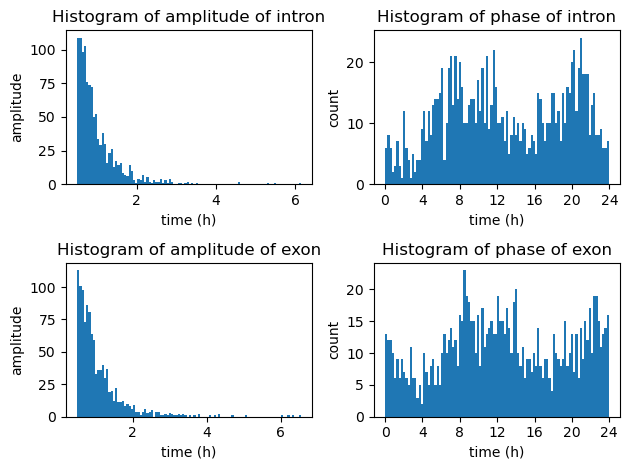

In [13]:
#using ii as index, extract the rythmic genes true in ii from results_intron and plot them in a histogram
amp_intron = results_intron['amp'][ii]
ph_intron = results_intron['phase'][ii]
amp_exon = results_exon['amp'][ii]
ph_exon = results_exon['phase'][ii]

#make a subplot with 4 histograms, one for amp_intron and one for ph_intron, one for amp_exon and one for ph_exon
#plot 1:
plt.subplot(2, 2, 1)
plt.hist(amp_intron, bins=100)
plt.title('Histogram of amplitude of intron')
plt.xlabel('time (h)')
plt.ylabel('amplitude')

#plot 2:
plt.subplot(2, 2, 2)
plt.hist(ph_intron, bins=100)
plt.title('Histogram of phase of intron')
plt.xlabel('time (h)')
plt.ylabel('count')
plt.xticks(np.arange(0, 28, 4))
#plot 3:
plt.subplot(2, 2, 3)
plt.hist(amp_exon, bins=100)
plt.title('Histogram of amplitude of exon')
plt.xlabel('time (h)')
plt.ylabel('amplitude')
#plot 4:
plt.subplot(2, 2, 4)
plt.hist(ph_exon, bins=100)
plt.title('Histogram of phase of exon')
plt.xlabel('time (h)')
plt.ylabel('count')
plt.xticks(np.arange(0, 28, 4))

#seperate the subplots wider
plt.tight_layout()
plt.show()

In [14]:
# Get the indices of the top 3 amplitudes in the original array
top_3_amplitude_indices_intron = np.argsort(results_intron['amp'][ii])[::-1][:3]
top_3_amplitude_indices_exon = np.argsort(results_exon['amp'][ii])[::-1][:3]

# Use these indices to get the corresponding gene names
top_3_genes_intron = results_intron['gene'][top_3_amplitude_indices_intron]
top_3_genes_exon = results_exon['gene'][top_3_amplitude_indices_exon]
top_3_genes_intron


array(['Pttg1ip', 'Naa20', 'Hpn'], dtype='<U14')

### Question 2
1. Related to Exercise 1, study the phase relationship between the pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis. 

2. Show representative profiles of genes with short or large delays.
  

3. Investigate (e.g. use a scatter plot) the relation between the phase difference between pre-mRNA and mRNA and the amplitude ratio (log2 fold change) of pre-mRNA and mRNA.
    * Discuss the plot? E.g. Mark some outliers with their gene names. *Hint*: Identify genes that show exceptionally large/small phase differences or amplitude ratios compared to the general trend. 



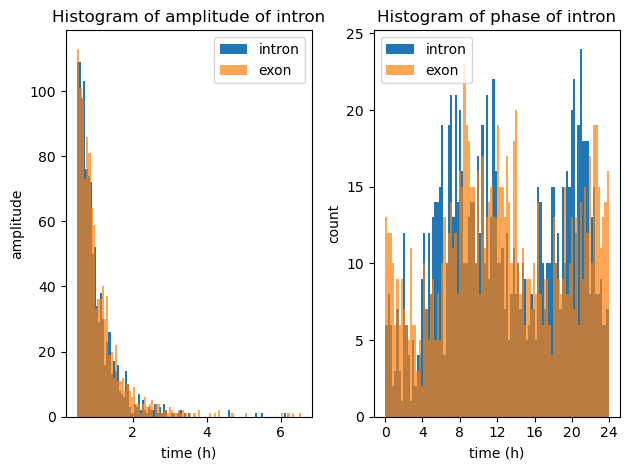

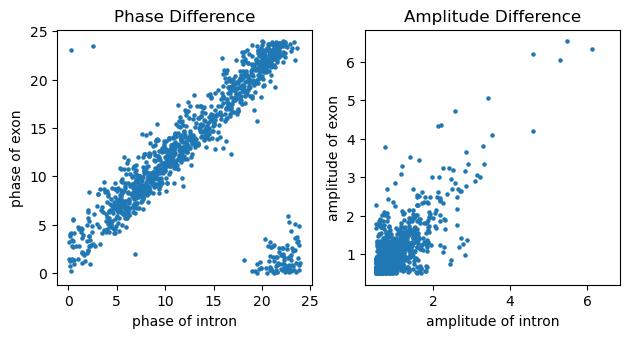

In [211]:
# Create logical filters to select only genes with rythmic behaviour 
xx = np.logical_and(results_intron['pv'] < 0.01, results_exon['pv'] < 0.01)
xx = np.logical_and(xx,results_intron['amp'] > 0.5)
xx = np.logical_and(xx,results_exon['amp'] > 0.5)


plt.subplot(1, 2, 1)
plt.hist(results_intron['amp'][xx], bins=100)
plt.hist(results_exon['amp'][xx], bins=100,alpha=0.7)
plt.title('Histogram of amplitude of intron')
plt.xlabel('time (h)')
plt.ylabel('amplitude')
plt.legend(['intron', 'exon'])
#plot 2:
plt.subplot(1, 2, 2)
plt.hist(results_intron['phase'][xx], bins=100)
plt.hist(results_exon['phase'][xx], bins=100,alpha=0.7)
plt.title('Histogram of phase of intron')
plt.xlabel('time (h)')
plt.ylabel('count')
plt.xticks(np.arange(0, 28, 4))
plt.legend(['intron', 'exon'])
plt.tight_layout()
plt.show()

#create new plot 
plt.subplot(1, 2, 1)
scat = plt.scatter(results_intron['phase'][xx], results_exon['phase'][xx], s=5)
plt.title('Phase Difference')
plt.xlabel('phase of intron')
plt.ylabel('phase of exon')
plt.axis('square')

plt.subplot(1, 2, 2)
plt.scatter(results_intron['amp'][xx], results_exon['amp'][xx], s=5)
plt.title('Amplitude Difference')
plt.xlabel('amplitude of intron')
plt.ylabel('amplitude of exon')
plt.axis('square')

plt.tight_layout()
plt.show()

### Q2.2 Show representative profiles of genes with short or large delays.

In [212]:
#Retrieve list of genes with short and large delay 
short_genes = []
long_genes=[]
diff = results_exon['phase'][xx]-results_intron['phase'][xx]

for i in range(len(diff)):
    if  4<diff[i]<7: # long delay
        long_genes.append(results_intron['gene'][xx][i]) 
    elif 0<diff[i]<0.5: # short delay
        short_genes.append(results_intron['gene'][xx][i])


In [213]:
def plot_profile(gene):
    replicate = ['A','B','C','D']  #choose all replicate 
    row_exon = []  # going to contain time series for each replicate 
    row_intron =[]
    dat_one_gene=dat[dat.index == gene] # retrieve time series for the gene of interest 
    
    for rep in replicate : 
        intron_mask = dat_one_gene.columns.get_level_values('feature').isin(['Intron'])
        replicate_mask = dat_one_gene.columns.get_level_values('replicate').isin([rep])
        exon_mask = dat_one_gene.columns.get_level_values('feature').isin(['Exon'])

        # Apply the masks to filter the DataFrame
        filtered_intron = dat_one_gene.loc[:,intron_mask & replicate_mask] #time series for the replicate, feature and gene we want 
        filtered_exon = dat_one_gene.loc[:,exon_mask & replicate_mask]
        row_intron.append(filtered_intron.iloc[0].to_numpy()) # create array with a row per replicate 
        row_exon.append(filtered_exon.iloc[0].to_numpy())
    
    #Average over the 4 replicates 
    mean_intron = np.mean(row_intron,axis=0)
    mean_exon = np.mean(row_exon,axis=0)
    
    #Get time points for plot 
    time = filtered_intron.columns.get_level_values('time')
    
    
    plt.plot(time, mean_intron, label='Intron',color='b')
    plt.plot(time,mean_exon,label = 'Exon',color='r')
                


    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(gene)
    plt.legend()
    plt.show()


#### Example of profiles for short delays 

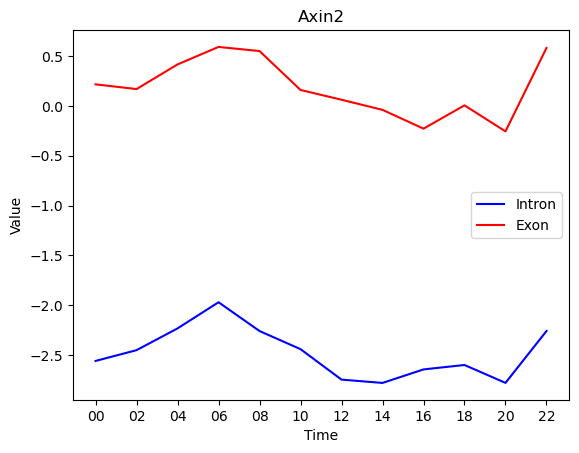

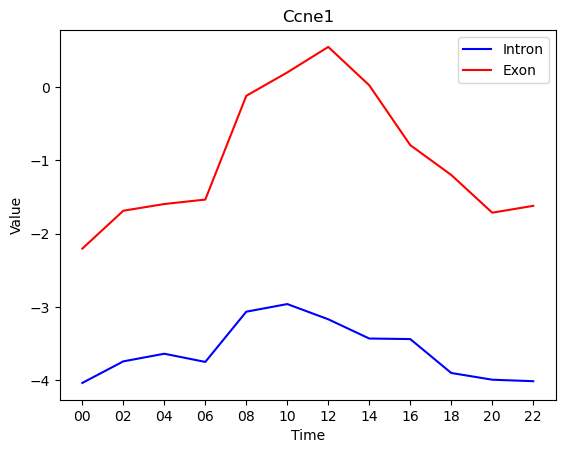

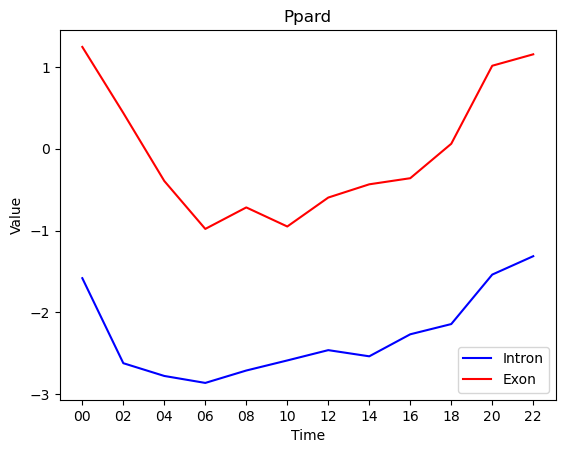

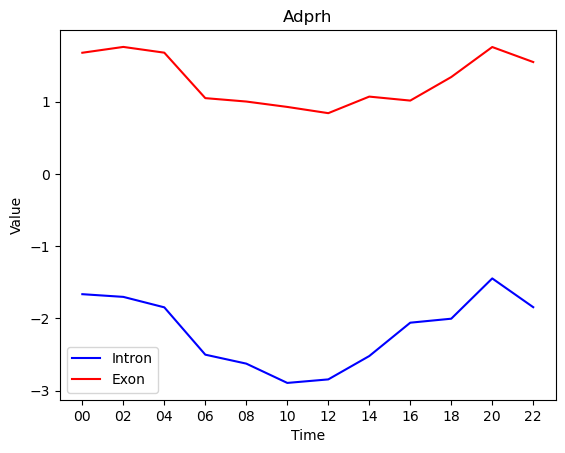

In [214]:
# We use the plot function over all the short genes and select representative profiles 
plot_profile('Axin2')
plot_profile('Ccne1')
plot_profile('Ppard')
plot_profile('Adprh')


#### Example of profiles for long delays 

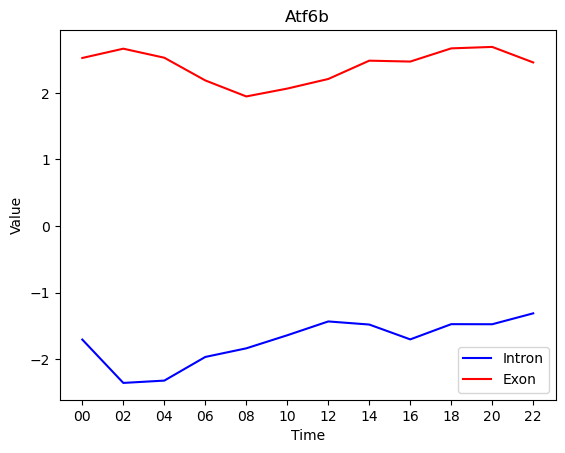

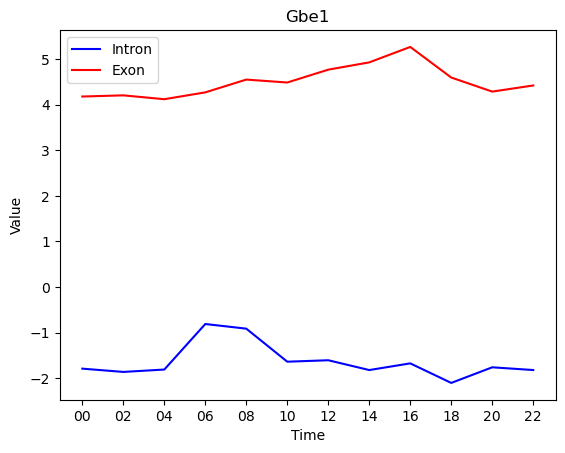

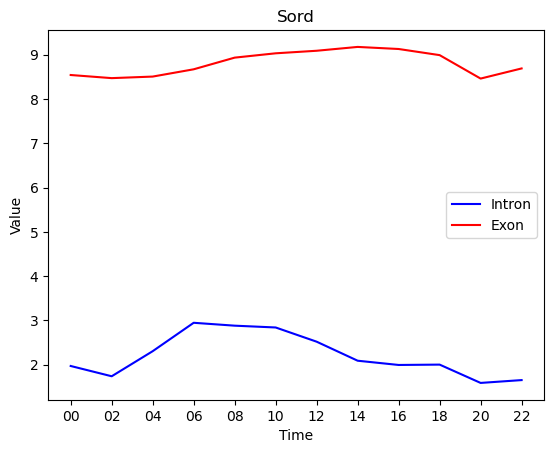

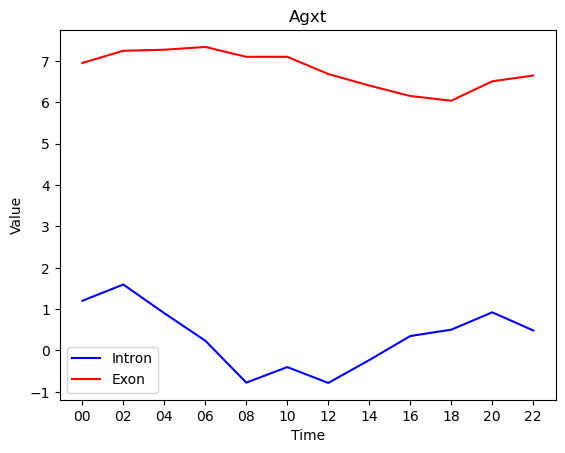

In [216]:
#Same process as for the short delays
plot_profile('Atf6b')
plot_profile('Gbe1')
plot_profile('Sord')
plot_profile('Agxt')

### Q2.3 Investigate (e.g. use a scatter plot) the relation between the phase difference between pre-mRNA and mRNA and the amplitude ratio (log2 fold change) of pre-mRNA and mRNA.
Discuss the plot? E.g. Mark some outliers with their gene names. *Hint*: Identify genes that show exceptionally large/small phase differences or amplitude ratios compared to the general trend. 

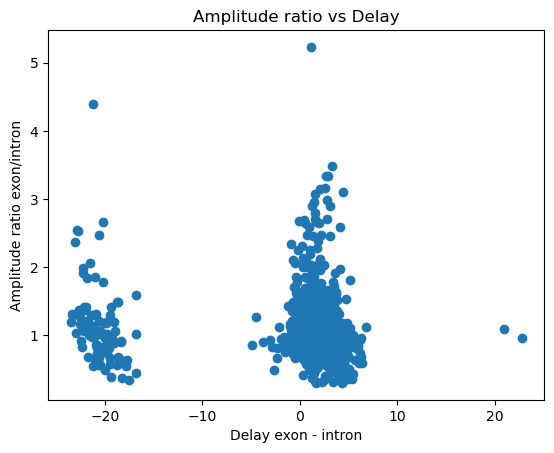

In [158]:
ratio_amp =results_exon['amp'][xx]/results_intron['amp'][xx] 
diff_phase = results_exon['phase'][xx]-results_intron['phase'][xx]

plt.scatter(diff_phase,ratio_amp)
plt.xlabel('Delay exon - intron')
plt.ylabel('Amplitude ratio exon/intron')
plt.title('Amplitude ratio vs Delay')
plt.show()

In [217]:
#Get the outliers by getting the three highest ratios (as we can observe that they are the outliers)
max_ratios = np.argpartition(ratio_amp, -3)[-3:] # index of the amp outliers

for ind in max_ratios :
    print(results_intron['gene'][ind])

Angptl4
Pih1d1
Trim25


In [218]:
#Get the outliers by observing the intervals of delays where there are few points
high_delays =[] # index of the delay outliers
for k in range(len(diff_phase)):
    if 6<diff_phase[k]<10 or -6>diff_phase[k]>-10 :
        high_delays.append(k)

for ind in high_delays :
    print(results_intron['gene'][ind])

Smarcb1
Acp5
Ddx18
Crnkl1
Bcl2l12
Eps8l1
Pdcl


We can observe that for the most frequent delays, ie around 2-4h and -20h (which are in the same delay interval with the modulo 24h), the amplitude ratio can go pretty high. It can go up around 4.5 and 5.5 for the most noticeable outliers. But what we can notice is that the further the point get from these 'common' delays, the less likely they seem to have a high amplitude ratio. The points that are out of the two principle clusters, have ratios that do not go above 1.5. 